In [ ]:
import torch
import matplotlib.pyplot as plt

from bliss.render_tiles import reconstruct_image_from_ptiles

# Preliminary tests

In [ ]:
ptiles = torch.randn(2, 10, 10, 1, 55, 55)
bp = 25
tile_slen = 5
mask = torch.ones_like(ptiles)
mask[..., bp:-bp, bp:-bp] = 0.0
mask = mask.bool()
ptiles[mask] = 0.0

In [ ]:
ptiles[0, 0, 0, 0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

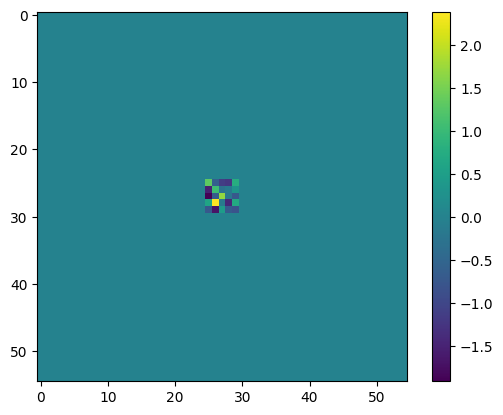

In [ ]:
plt.imshow(ptiles[0, 0, 0, 0])
plt.colorbar()

In [ ]:
images = reconstruct_image_from_ptiles(ptiles, tile_slen)

In [ ]:
images.shape

torch.Size([2, 1, 100, 100])

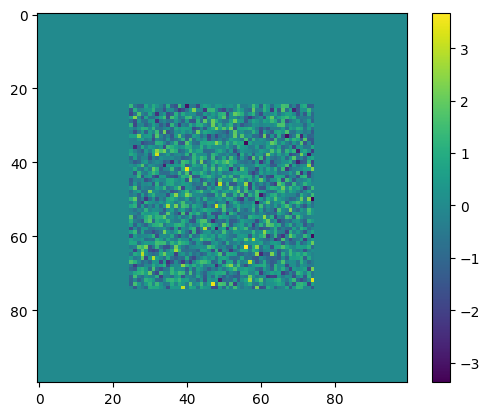

In [ ]:
plt.imshow(images[0, 0])
plt.colorbar()

In [ ]:
from bliss.render_tiles import get_images_in_tiles
_ptiles = get_images_in_tiles(images, 5, 55)
_ptiles.shape

torch.Size([2, 5, 5, 1, 55, 55])

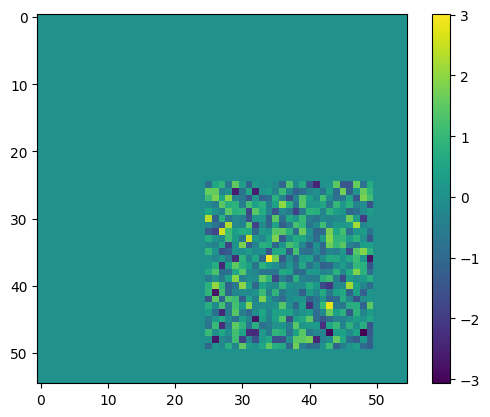

In [ ]:
plt.imshow(_ptiles[0, 0, 0, 0])
plt.colorbar()

In [ ]:
# test encoder networks like it
from bliss.encoders.detection import DetectionEncoder

In [ ]:
det = DetectionEncoder(tile_slen=5, ptile_slen=55)

In [ ]:
ptiles.shape

torch.Size([2, 5, 5, 1, 55, 55])

In [ ]:
from einops import rearrange, unpack


flat_ptiles = rearrange(ptiles, 'n nh nw 1 h w -> (n nh nw) 1 h w')
flat_ptiles.shape

torch.Size([50, 1, 55, 55])

In [ ]:
enc_conv_output = det._enc_conv(flat_ptiles)
enc_final_output = det._enc_final(enc_conv_output)

# split NN output
locs_mean_raw, locs_logvar_raw, n_source_free_probs = unpack(
    enc_final_output, [(2,), (2,), ()], "np *"
)

In [ ]:
n_source_free_probs.shape, locs_mean_raw.shape

(torch.Size([50]), torch.Size([50, 2]))

# With images sanity check

In [ ]:
from bliss.datasets.padded_tiles import generate_padded_tiles
from bliss.datasets.generate_blends import generate_dataset
from bliss.datasets.lsst import prepare_final_galaxy_catalog, prepare_final_star_catalog, get_default_lsst_psf

cat = prepare_final_galaxy_catalog()
scat = prepare_final_star_catalog()
psf = get_default_lsst_psf()

In [ ]:
ds = generate_dataset(2, cat, scat, psf, max_n_sources=10, galaxy_density=150, star_density=0.0, slen=40, bp=24, add_galaxies_in_padding=False)

100%|██████████| 2/2 [00:00<00:00, 27.59it/s]


In [ ]:
ds.keys()

dict_keys(['images', 'noiseless', 'uncentered_sources', 'centered_sources', 'paddings', 'plocs', 'n_sources', 'galaxy_bools', 'star_bools', 'galaxy_params', 'star_fluxes', 'fluxes'])

In [ ]:
images = ds['images']
noiseless = ds['noiseless']
images.shape

torch.Size([2, 1, 88, 88])

In [ ]:
params = {k:v for k,v in ds.items() if k in ('n_sources', 'plocs', 'galaxy_bools', 'star_bools')}

In [ ]:
from bliss.catalog import FullCatalog
fcat = FullCatalog(40, 40, params)
tile_cat = fcat.to_tile_params(4)

In [ ]:
tile_cat.n_sources.shape

torch.Size([2, 10, 10])

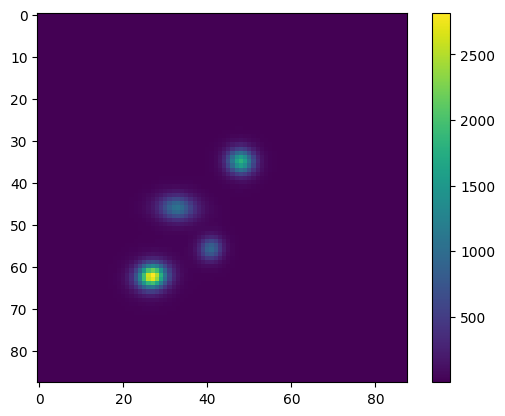

In [ ]:
plt.imshow(noiseless[0, 0])
plt.colorbar()

In [ ]:
ptiles.shape

torch.Size([2, 10, 10, 1, 52, 52])

In [ ]:
tile_cat.n_sources[0]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
from bliss.render_tiles import get_images_in_tiles
ptiles = get_images_in_tiles(noiseless, 4, 52)
ptiles[~tile_cat.n_sources.bool()] = 0.0 # avoid repetition

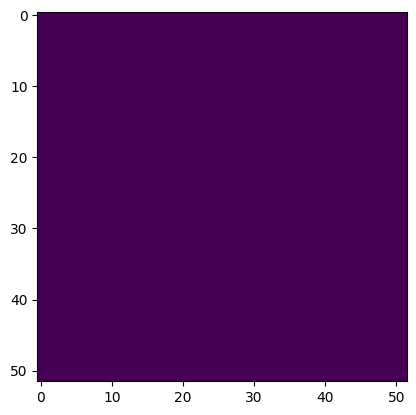

In [ ]:
plt.imshow(ptiles[0,0,0,0])


In [ ]:
_images = reconstruct_image_from_ptiles(ptiles, 4)
_images.shape

torch.Size([2, 1, 88, 88])

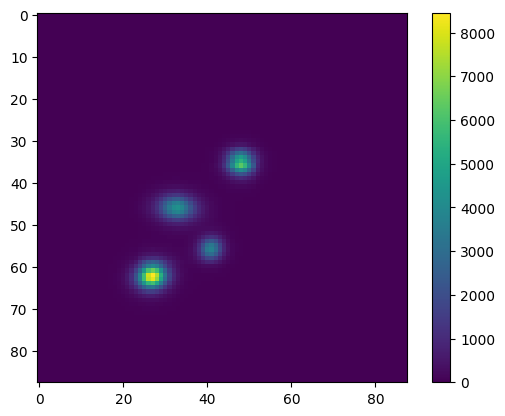

In [ ]:
plt.imshow(_images[0,0])
plt.colorbar()

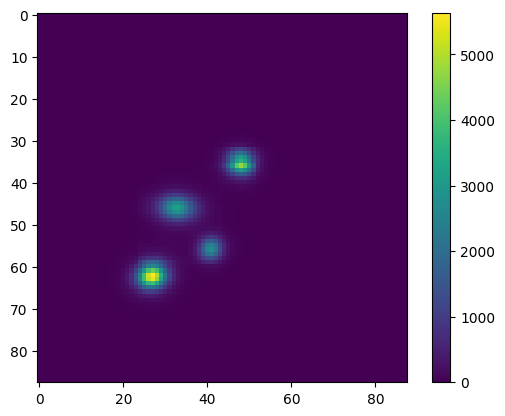

In [ ]:
plt.imshow(_images[0, 0] - noiseless[0, 0])
plt.colorbar()